# Brand Topic Analysis
The purpose of this project is to analyze what kind of topics people talk about a certain brand. This project is focused at text data where the process consists of text preprocessing and topic modelling. Data used in this project is obatained from Twitter API. The usage of tweets data that contain the brand name is due to it is one of the most effectve way to capture customers or people opinion about the brand.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re, string, unicodedata #regular expression
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud, STOPWORDS

Dataframe is tweets that contain 'gojek', as I want to analyze the brand sentiment. I use Orange software to get the tweets data because it is the quickest and I can get more tweets compared to tweepy.

In [2]:
df = pd.read_csv('gojek.csv')
df.head()

,In Reply To,Author,Content,Date,Number of Likes,Number of Retweets
0,discrete,discrete,string,time,continuous,continuous
1,NaN,class,meta title=True,meta,meta,meta
2,NaN,@kumisantuy,"Chat terakhir tadi sore isinya:\n""Aku tudur ya...",2020-08-01 13:43:24,0.0,0.0
3,@troesure,@nvishinoya,@troesure SERIUS.... gw suka degdegan klo lg n...,2020-08-01 13:42:10,0.0,0.0
4,@krimykripy,@krimykripy,@collegemenfess dan pas hp uda mati ternyata p...,2020-08-01 13:41:33,0.0,0.0


In [3]:
df = df.iloc[2:,:]
df.head()

,In Reply To,Author,Content,Date,Number of Likes,Number of Retweets
2,NaN,@kumisantuy,"Chat terakhir tadi sore isinya:\n""Aku tudur ya...",2020-08-01 13:43:24,0.0,0.0
3,@troesure,@nvishinoya,@troesure SERIUS.... gw suka degdegan klo lg n...,2020-08-01 13:42:10,0.0,0.0
4,@krimykripy,@krimykripy,@collegemenfess dan pas hp uda mati ternyata p...,2020-08-01 13:41:33,0.0,0.0
5,@collegemenfess,@krimykripy,@collegemenfess inget banget dulu pertama ke k...,2020-08-01 13:41:19,0.0,0.0
6,@shellirachel,@findayaindo,"@shellirachel Hai kak, kami dari Findaya partn...",2020-08-01 13:41:12,0.0,0.0


# Preprocessing

Preprocessing text data (tweet contents) consists of removing URLs and special characters, then, transform slang words to their appropriate forms, stem, and tokenize.

I use https://github.com/nasalsabila/kamus-alay as the dictionary to transform slang words.

In [4]:
#load slang words dictionary
slang_dictionary = pd.read_csv('colloquial-indonesian-lexicon.csv')
slang_dict = pd.Series(slang_dictionary['formal'].values,index=slang_dictionary['slang']).to_dict()

In [5]:
#set stopwords
stop_words = set(stopwords.words('indonesian'))

#add words that aren't in the NLTK stopwords list
new_stopwords = ['gojek','sy', 'karna', 'gue', 'pun', 'nya', 'yg', 'gw', 'ke', 'gak', 
                 'ga', 'buat', 'selama', 'akan', 'gua', 'gw', 'gue', 'banget', 
                 'mohon', 'dii', 'kalo', 'dll', 'cuman', 'cuma', 'biar', 'kayak', 
                 'ssaja', 'sih', 'si', 'situ', 'e', 'diin', 'serba', 'untuj', 'deh', 
                 'jd', 'ku', 'lg', 'and', 'tuh', 'nih', 'mas', 'mbak', 'tau', 'iya',
                 'ya', 'lu', 'pas', 'wkwk', 'haha', 'wkwkwk', 'wkwkw', 'wow', 'akak',
                 'anjir', 'lo', 'loh', 'bang', 'kak', 'twit', 'eh', 'oh', 'yuk', 'gila',
                 'asa', 'mending', 'engenggak', 'a', 'mah', 'kali']
new_stopwords_list = stop_words.union(new_stopwords)

#remove words that are in NLTK stopwords list
not_stopwords = {'ibu', 'bapak'} 
final_stop_words = set([word for word in new_stopwords_list if word not in not_stopwords])

In [6]:
#preprocessing functions

#transform slang words and abbreviations
def Slangwords(text):
    for word in text.split():
        if word in slang_dict.keys():
            text = text.replace(word, slang_dict[word])
    return text

#Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#remove stopwords
def RemoveStopwords(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [word for word in word_tokens if not word in final_stop_words]
    return ' '.join(filtered_sentence)

#clean text from special characters, digits, and turn them into lowercase
def Clean(text):
    #remove non-ascii
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #remove URLs
    text = re.sub(r'http\S+', ' ', text, flags=re.MULTILINE)
    
    #remove punctuations
    text = re.sub(r'[^\w]|_',' ', text)
    
    #remove digits
    text = re.sub('\S*\d\S*', ' ', text).strip()
    text = re.sub(r'\b\d+\b', ' ', text)
    
    #turn all words to lowercase
    text = text.lower()
    
    #remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    
    return text

In [7]:
#new column for processed text data
df['content_processed'] = ''

#run functions
for i, row in df.iterrows():
    content = df.Content[i]
    result = Clean(content)
    result = Slangwords(result)
    result = stemmer.stem(result)
    result = RemoveStopwords(result)
    df['content_processed'][i] = result

Plot wordcloud to check most common words and make sure all of the words are meaningful

In [8]:
all_text = " ".join( desc for desc in df.content_processed)

print('There are {} words in the combination of all content_processed.'.format(len(all_text)))

There are 419700 words in the combination of all content_processed.


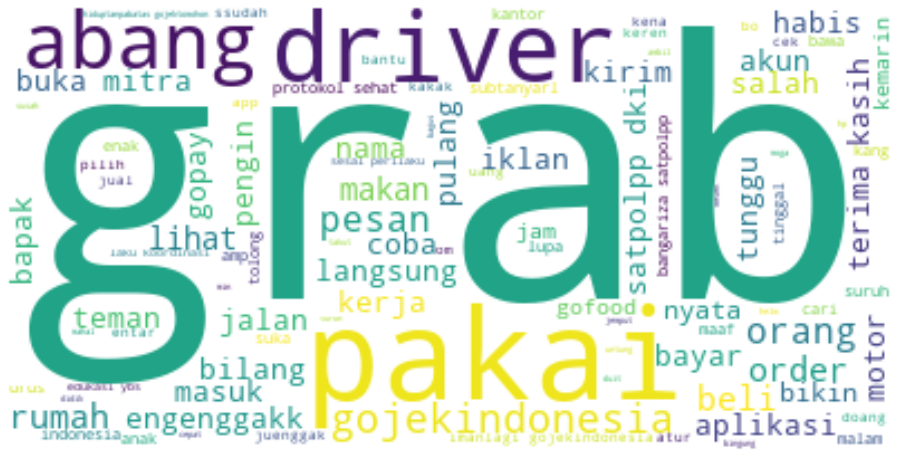

In [9]:
wordcloud_all = WordCloud(max_font_size=160, max_words=100, background_color='white').generate(all_text)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
df['content_processed']

2                             chat sore isi tudur barusan
3        troesure serius suka degdegan nggu for no reason
4       collegemenfess hp ssudahh mati nyata posisi or...
5       collegemenfess kota rantau tanin ibu kos cari ...
6       shellirachel hai findaya partner tangan paylat...
                              ...                        
6704              andhikarais gojekindonesia admin gapapa
6705                       ponakannyaom salah daftar liga
6706                                   ui saiki mbingungi
6707    ardhtafw komunitas facebook kalah komunitas ab...
6708    kfcindonesia kfc tolol kluarin ayam lime apps ...
Name: content_processed, Length: 6707, dtype: object

In [17]:
df.to_csv('gojek_processed.csv', index=False)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6707 entries, 2 to 6708
Data columns (total 7 columns):
In Reply To           4338 non-null object
Author                6707 non-null object
Content               6707 non-null object
Date                  6707 non-null object
Number of Likes       6707 non-null object
Number of Retweets    6707 non-null object
content_processed     6707 non-null object
dtypes: object(7)
memory usage: 366.9+ KB
